# Домашняя работа 2

В этой доамшней работе вам предлагается обучить классификатор, распознающий вид блюда по фотографии. Прямо как на семинаре, только больше разной еды!

 # Home Work 2

In this hw assignment you have to train a classifier to distinguish between different food variations. Just like at our practice, but with more foods variety!

## Но сперва... Теория
Необходимо решить теоретические задачи, используя Latex, внутри этого ноутбука
## But first... Theory
Solve the theoretical problems. Type the solutions here, using Latex

### Задача 1 (2 балла)
### Problem 1 (2 points)

Посчитайте результат применения операции свертки с ядром K к матрице X. Параметры свертки следующие: stride=2, dilation=2, padding=1 (паддинг осуществляется нулями).

Compute the result of convolution operation with kernel K to a matrix X.
Convolution params are: stride=2, dilation=2, padding=1 (padding with zeros)


$        X = \begin{bmatrix}
        1 & 0 & -4 & 2 \\
        5 & 2 & 3 & 0 \\
        -1 & 0 & 1 & 4 \\
        0 & -3 & 2 & -1
    \end{bmatrix}
    K = \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix}
$

#### Решение  ================= Solution
Ответ будет: <br>
-2 8 -2 <br>
7 5 -4<br>
0 -4 -2


### Задача 2 (2 балла)
### Problem 2 (2 points)

Посчитайте число обучаемых параметров в нейронной сети, архитектура которой выглядит следующим образом:

        model = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=5,
                stride=2, padding=0, dilation=1, bias=True
            ),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5,
                stride=1, padding=1, dilation=2, bias=False
            ),
            nn.BatchNorm2d(num_features=32),
            nn.Sigmoid(),
        )
  

#### Решение =================== Solution

первый слой nn.Conv2d. В нем in_channels = 3, out_channels = 16, размер ядра 5x5, stride = 2, padding = 0, bias = True, поэтому количество параметров: (3 * 5 * 5 + 1) * 16 = 1216.

Далее идет слой nn.BatchNorm2d с num_features = 16, в котором количество параметров равно 2 * 16 = 32.

Вторая свертка nn.Conv2d имеет in_channels = 16, out_channels = 32, ядро 5x5, stride = 1, padding = 1, dilation = 2, bias = False, что дает: (16 * 5 * 5) * 32 = 12800 параметров.

Следующий слой — nn.BatchNorm2d с num_features = 32, где число параметров равно 2 * 32 = 64.

Слои активации LeakyReLU и Sigmoid не добавляют параметров.

В итоге общее количество обучаемых параметров: 1216 + 32 + 12800 + 64 = 14012.

### Практическое задание
### Practical problem

Вам необходимо решить задачу многоклассовой классификации для датасета Food101

Solve multicalss classification problem for Food101 dataset

####  Служебный код

In [6]:
import copy
import random
import os
import shutil
import tarfile
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Dataset

pd.set_option('display.max_colwidth', None)

In [7]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [8]:
url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"

In [9]:
dataset_directory = os.path.join(os.environ["HOME"], "datasets/food101")

In [10]:
filepath = os.path.join(dataset_directory, "food101.tar.gz")
download_url(
    url=url,
    filepath=filepath,
)
%time extract_archive(filepath)

food101.tar.gz: 100%|██████████| 4.65G/4.65G [02:40<00:00, 31.1MB/s]    


CPU times: user 48.3 s, sys: 18.4 s, total: 1min 6s
Wall time: 1min 6s


In [11]:
dataset_directory

'/root/datasets/food101'

### Dataloaders (1 point)


In [12]:
from torchvision.datasets import ImageFolder
NUM_WORKERS = os.cpu_count()


def split_data(dataset, val_size=0.2, seed=42):
    """
    """
    generator = torch.Generator().manual_seed(seed)
    train_data, test_data = random_split(dataset, [1 - val_size, val_size], generator=generator)

    return train_data, test_data


def create_dataloaders(
    data_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """

  dataset = datasets.ImageFolder(root='/root/datasets/food101/food-101/images', transform=manual_transforms)


  train_data, test_data = split_data(dataset)



  class_names = dataset.classes

  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

  return train_dataloader, test_dataloader, class_names

In [13]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [14]:
from pathlib import Path

data_path = Path(dataset_directory)
image_path = data_path / "food-101" / "images"

 Опишите трасформы. Можно добавить аугментаций для лучшего результата.

 Можете использовать библиотеку  Albumentation или torchvision

  Не забудьте отмасштабировать размер картинов и нормализовать их

In [15]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 1. Reshape data HxW to fit model
    transforms.ToTensor(),  # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])  # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])


train_data = ImageFolder(image_path, transform=manual_transforms)

In [16]:
train_data, test_data = split_data(train_data)

In [17]:
batch_size = 32
num_workers = 4

 #### Train function (2 points)


Напишите функцию трейна. Мы делали нечто похожее на семинаре

In [18]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
     # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    # Do the rest
    # Hint: torch.no_grad() / torch.inference_mode()

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)


    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)


    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, f"{epochs}_iter.pth")

    # Return the filled results at the end of the epochs
    return results

Выберете модель из доступных

In [19]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s] 


Заморозьте некоторые слои или обучайте модель целиком

In [20]:
###
### Выберете слои, через которые не будут течь градиенты
###

# Заморозка всех слоев, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Разморозка последнего слоя (или нескольких последних слоев)
for param in model.layer4.parameters():
    param.requires_grad = True

# Замена последнего полносвязного слоя
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(train_data.dataset.classes))


Взглянем на модель

In [21]:
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 101]            --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### Train (1 point)

In [22]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
n_epochs = 10

In [23]:
### Получите данные

train_dataloader, test_dataloader, class_names = create_dataloaders(
    data_dir=image_path,
    transform=manual_transforms,
    batch_size=batch_size,
    num_workers=num_workers
)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3613 | train_acc: 0.6490 | test_loss: 0.9429 | test_acc: 0.7495
Epoch: 2 | train_loss: 0.7105 | train_acc: 0.8061 | test_loss: 0.8770 | test_acc: 0.7692
Epoch: 3 | train_loss: 0.4269 | train_acc: 0.8791 | test_loss: 0.9017 | test_acc: 0.7697
Epoch: 4 | train_loss: 0.2421 | train_acc: 0.9299 | test_loss: 0.9048 | test_acc: 0.7818
Epoch: 5 | train_loss: 0.1510 | train_acc: 0.9556 | test_loss: 0.9649 | test_acc: 0.7802
Epoch: 6 | train_loss: 0.1126 | train_acc: 0.9665 | test_loss: 1.0170 | test_acc: 0.7677
Epoch: 7 | train_loss: 0.0903 | train_acc: 0.9735 | test_loss: 1.0504 | test_acc: 0.7700
Epoch: 8 | train_loss: 0.0792 | train_acc: 0.9766 | test_loss: 1.0861 | test_acc: 0.7674
Epoch: 9 | train_loss: 0.0656 | train_acc: 0.9808 | test_loss: 1.1265 | test_acc: 0.7663
Epoch: 10 | train_loss: 0.0581 | train_acc: 0.9827 | test_loss: 1.1328 | test_acc: 0.7710
[INFO] Total training time: 2588.889 seconds


### Results (2 points in total)
Отрисуйте графики лосса для трейна и валидации

Продемонстрируйте работу сетки на каких-нибудь картинках. Помните, что для тестирования лучше иметь отдельный тестовый сет. Для этого либо сами, либо с помощью кода, который был на прошлом семинаре, скачайте несколько фотографий с едой и попробуйте распознать ее.

Либо заранее отложите некоторое кол-во фотографий в тестовую выборку. Из кода должно быть понятно, что вы это сделали.

Это, например, можно сделать, поделив data_test на две выборки с помощью функции split_data, которая у вас есть




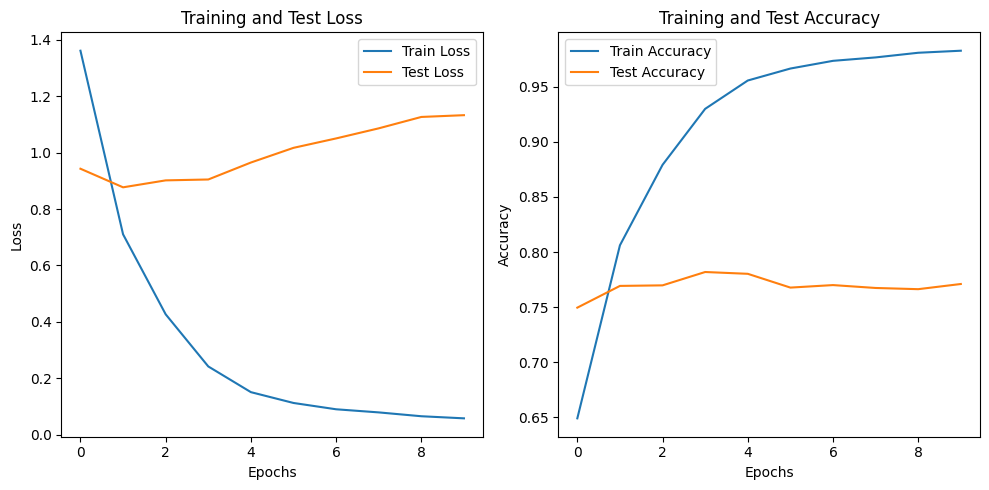

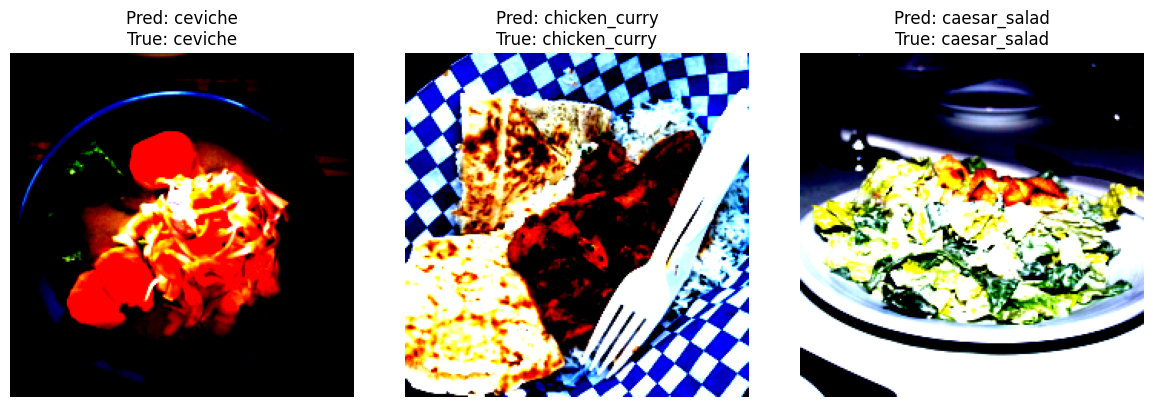

In [28]:
from matplotlib import pyplot as plt
# Построение графиков потерь
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train Loss')
plt.plot(results['test_loss'], label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='Train Accuracy') 
plt.plot(results['test_acc'], label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Создание отдельного тестового набора
test_data_split, val_data_split = torch.utils.data.random_split(
    test_data, 
    [int(len(test_data)*0.5), len(test_data)-int(len(test_data)*0.5)]
)

# Создание даталоадера для финального тестирования
final_test_dataloader = DataLoader(
    test_data_split,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# Тестирование модели на нескольких изображениях
model.eval()
with torch.no_grad():
    # Получаем batch изображений
    test_features, test_labels = next(iter(final_test_dataloader))
    test_features = test_features.to(device)
    test_predictions = model(test_features)
    
    # Отображаем результаты
    plt.figure(figsize=(12, 4))
    for idx in range(3):  # показываем первые 3 изображения
        plt.subplot(1, 3, idx+1)
        img = test_features[idx].cpu().permute(1, 2, 0)
        plt.imshow(img)
        pred_label = class_names[test_predictions[idx].argmax()]
        true_label = class_names[test_labels[idx]]
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Graphs (1 point)
Plot graphs for train and val loss

Графикии трейн и вал лосса

In [32]:
for root, folders, filenames in os.walk('/kaggle/input'):
   print(root, folders)

/kaggle/input ['testing-foods']
/kaggle/input/testing-foods []


Prediction for /kaggle/input/testing-foods/another.jpg: pizza


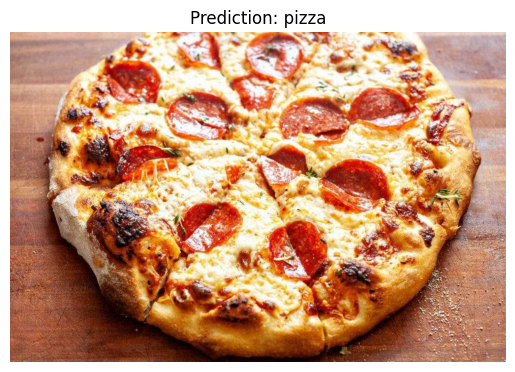

Prediction for /kaggle/input/testing-foods/burger.jpg: hamburger


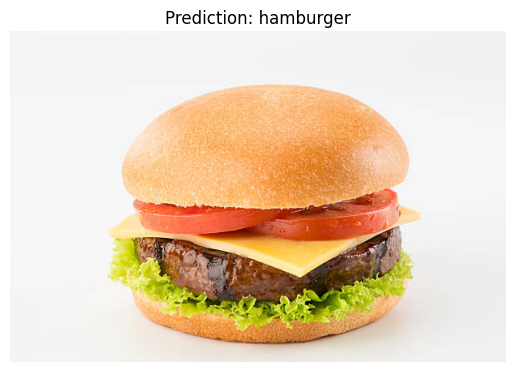

Prediction for /kaggle/input/testing-foods/pizza.jpg: pizza


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_custom_image(image_path, model, transform, class_names):
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor)
        predicted_class = class_names[prediction.argmax().item()]
        
    return predicted_class

def display_image_with_prediction(image_path, prediction):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Prediction: {prediction}")
    plt.axis('off')  # Hide the axes
    plt.show()

# Test on custom images
custom_image_paths = ['/kaggle/input/testing-foods/another.jpg', '/kaggle/input/testing-foods/burger.jpg', '/kaggle/input/testing-foods/pizza.jpg']
for path in custom_image_paths:
    pred = predict_custom_image(path, model, manual_transforms, class_names)
    print(f"Prediction for {path}: {pred}")
    display_image_with_prediction(path, pred)


#### Demonstration (1 point)

 Покажите качество работы модели, прогнав несколько фотографий через нее